In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.decomposition import PCA


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Carregando os dados
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/trabalho-final-AM/dataset/enron_spam_data.csv')
df['text'] = df['Subject'].fillna('') + ' ' + df['Message'].fillna('')
df = df.drop_duplicates(keep='first')


In [4]:
X = df['text']
y = df['Spam/Ham']

In [5]:
X.shape

(33716,)

In [6]:
y.shape

(33716,)

In [7]:
# Separando treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Selecionar apenas as mensagens 'spam' para treinamento
X_train_spam = X_train[y_train == 'spam']

X_train_spam.shape

(13736,)

In [8]:
X_test

15849    watch this hot pick fly bio - matrix scientifi...
9929     [ ilug ] manuel oko attn : sir / madan\nstrict...
4803     investment news : hot stock this week ! " the ...
205      re : equistar fyi . . . only ! this activity h...
15786    giga ph . armacy u can trsut welcome to health...
                               ...                        
19635    best source for health supplements page is loa...
11776    weekly deal report the following is the weekly...
31123    accept plnnacle system , corel , allas , apple...
8682     research ' s summer outlook the research weath...
18456    ? a????? - ????????? 2004\n????? ???? ??? ? ??...
Name: text, Length: 6744, dtype: object

In [9]:
# Transformação TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_train_spam_tfidf = vectorizer.fit_transform(X_train_spam)
X_test_tfidf = vectorizer.transform(X_test)


In [10]:
X_test_tfidf.shape

(6744, 500)

In [11]:
# Treinamento do GMM
gmm = GaussianMixture(n_components=10, covariance_type='tied', random_state=42)
gmm.fit(X_train_spam_tfidf.toarray())


GaussianMixture(covariance_type='tied', n_components=10, random_state=42)

In [12]:
# Detecção de Anomalias nos dados de teste
log_likelihood = gmm.score_samples(X_train_spam_tfidf.toarray())
log_likelihood_teste = gmm.score_samples(X_test_tfidf.toarray())

In [13]:
log_likelihood_teste_negativo = -log_likelihood_teste

In [14]:
y_test_bin = np.where(y_test == 'ham', 1, 0)

fpr, tpr, thresholds = roc_curve(y_test_bin, log_likelihood_teste_negativo)

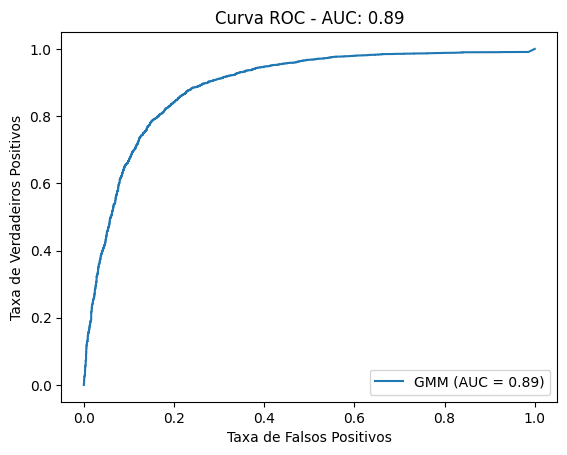

In [15]:
# Calculando a AUC
roc_auc = roc_auc_score(y_test_bin, log_likelihood_teste_negativo)

# Plotando a curva ROC
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='GMM')
roc_display.plot()

# Adicionando título e legendas
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title(f'Curva ROC - AUC: {roc_auc:.2f}')
plt.show()

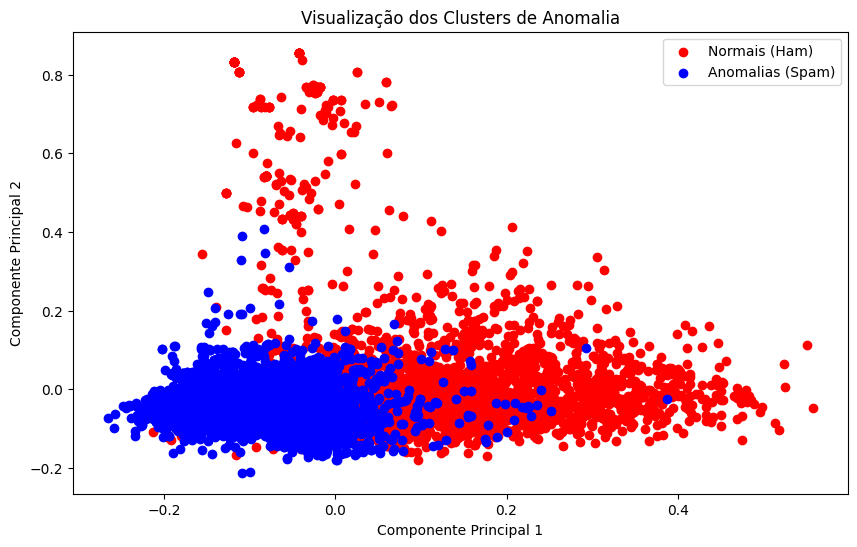

In [16]:
# Visualização dos grupos formados

# Reduzindo a dimensionalidade para 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_tfidf.toarray())

# Convertendo y_test para array booleano onde verdadeiro representa 'ham'
spam_indices = y_test == 'ham'

plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[spam_indices, 0], X_test_pca[spam_indices, 1], color='red', label='Normais (Ham)')
plt.scatter(X_test_pca[~spam_indices, 0], X_test_pca[~spam_indices, 1], color='blue', label='Anomalias (Spam)')
plt.title('Visualização dos Clusters de Anomalia')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()


In [17]:
log_likelihood_teste_negativo

array([ -900.77341108,  -720.44701907,  -913.22080156, ...,
       -1081.84918328,  -385.57846769,  -949.37519821])

In [18]:
from sklearn.metrics import precision_recall_fscore_support

best_f1 = 0
best_threshold = 0
for threshold in np.linspace(min(log_likelihood_teste_negativo), max(log_likelihood_teste_negativo), 100):
    y_pred = np.where(log_likelihood_teste_negativo > threshold, 1, 0)
    precisao, recall, f1, _ = precision_recall_fscore_support(y_test_bin, y_pred, average='binary')

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best F1: {best_f1:.2f} with threshold: {best_threshold:.2f}")


Best F1: 0.79 with threshold: -857.66


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

threshold = best_threshold

# Classificação binária com base no limiar
y_pred = np.where(log_likelihood_teste_negativo  > threshold, 1, 0)  # 1 para 'ham', 0 para 'spam'

# Cálculo das métricas
acuracia = accuracy_score(y_test_bin, y_pred)
precisao = precision_score(y_test_bin, y_pred)
recall = recall_score(y_test_bin, y_pred)
f1 = f1_score(y_test_bin, y_pred)

# Exibição dos resultados
print(f"Acurácia: {acuracia :.2f}%")
print(f"Precisão: {precisao :.2f}%")
print(f"Recall: {recall :.2f}%")
print(f"F1-score: {f1 :.2f}%")


Acurácia: 0.81%
Precisão: 0.85%
Recall: 0.74%
F1-score: 0.79%


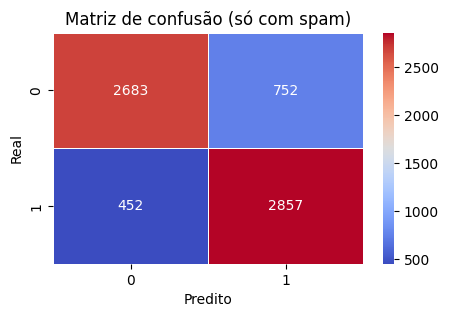

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Visualizar a correlação entre matriz usando a mapa de calor
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix(y_test_bin,y_pred), annot=True, cmap='coolwarm', fmt=".0f", linewidths=.5)
plt.title('Matriz de confusão (só com spam)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()